# Task
Use Python and the AI Fairness 360 toolkit to audit the "compas.db" SQLite database for racial bias in COMPAS risk scores. Generate visualizations to illustrate disparities, such as in false positive rates. Finally, write a 300-word report summarizing your findings and proposing remediation steps.

## Install ai fairness 360

### Subtask:
Install the `aif360` library.


**Reasoning**:
The first step is to install the necessary library, `aif360`, as instructed.



In [1]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.0 MB/s eta 0:00:00


## Load the data

### Subtask:
Load the COMPAS dataset from the "compas.db" SQLite database.


**Reasoning**:
Load the data from the SQLite database into a pandas DataFrame.



In [2]:
import sqlite3
import pandas as pd

# Establish a connection to the database
conn = sqlite3.connect('compas.db')

# Write a SQL query to select all data from the people table
query = "SELECT * FROM people"

# Use pandas to execute the query and load the data into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the first few rows of the DataFrame
display(df.head())

DatabaseError: Execution failed on sql 'SELECT * FROM people': no such table: people

**Reasoning**:
The previous attempt failed because the table `people` does not exist. I need to first inspect the database to find the correct table name. I will list all tables in the database and then use the correct table name to load the data.



In [3]:
import sqlite3
import pandas as pd

# Establish a connection to the database
conn = sqlite3.connect('compas.db')

# Get the list of tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"Tables in the database: {tables}")

# Assuming the table name is 'compas' based on the file name.
# If not, I will adjust after seeing the output of the print statement.
# For now, let's try with 'compas' as the table name.
query = "SELECT * FROM compas"

try:
    # Use pandas to execute the query and load the data into a DataFrame
    df = pd.read_sql_query(query, conn)
    display(df.head())
except Exception as e:
    print(e)
    # If the table name is still wrong, I will get another error.
    # In that case, I will use the correct table name from the printed list.
    if tables:
        correct_table_name = tables[0][0]
        print(f"Trying with table name: {correct_table_name}")
        query = f"SELECT * FROM {correct_table_name}"
        df = pd.read_sql_query(query, conn)
        display(df.head())

# Close the database connection
conn.close()

Tables in the database: []
Execution failed on sql 'SELECT * FROM compas': no such table: compas


**Reasoning**:
The database seems to be empty or the file is not a valid SQLite database. Since the user wants to load data from "compas.db" and the previous attempts to read from it failed because there are no tables, I will try to see if the file exists and is a valid database file. It's possible the file is corrupted or not a database file at all. I'll use the `os` module to check if the file exists. If it does, I'll try to connect and re-check for tables. If it doesn't, I'll report the failure. Since the file is expected to be in the current directory, I will check the current working directory.



In [4]:
import os
import sqlite3
import pandas as pd

db_file = 'compas.db'

if os.path.exists(db_file):
    print(f"'{db_file}' exists.")
    try:
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        print(f"Tables in the database: {tables}")
        if not tables:
            print("The database is empty.")
        conn.close()
    except sqlite3.DatabaseError as e:
        print(f"Error connecting to or reading from the database: {e}")
else:
    print(f"'{db_file}' does not exist in the current directory.")


'compas.db' exists.
Tables in the database: []
The database is empty.


## Preprocess the data

### Subtask:
Prepare the data for analysis with AI Fairness 360. This will involve selecting relevant features and converting the data into the format expected by the toolkit.


**Reasoning**:
Load the data from the provided CSV file into a pandas DataFrame and select the relevant columns.



In [5]:
import pandas as pd
from aif360.datasets import StandardDataset

# Load the data from the CSV file
df = pd.read_csv('/data/compas-scores-two-years.csv')

# Select the relevant columns
selected_columns = [
    'sex',
    'age',
    'race',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
    'is_recid',
    'two_year_recid',
    'decile_score',
]
df_selected = df[selected_columns]

# Convert the selected DataFrame into an aif360.datasets.StandardDataset object
# Define protected attribute, label, favorable/unfavorable labels, and reference/privileged groups
protected_attribute_names = ['race']
label_names = ['two_year_recid']
favorable_label = 0
unfavorable_label = 1
privileged_attributes = [{'race': 'Caucasian'}]
unprivileged_attributes = [{'race': 'African-American'}]

compas_dataset = StandardDataset(
    df_selected,
    protected_attribute_names=protected_attribute_names,
    privileged_attributes=privileged_attributes,
    unprivileged_attributes=unprivileged_attributes,
    host_dataset=None,
    categorical_features=['sex', 'c_charge_degree', 'c_charge_desc'],
    features_to_keep=selected_columns,
    features_to_drop=[],
    label_names=label_names,
    favorable_label=favorable_label,
    unfavorable_label=unfavorable_label,
)

# Display the first few rows of the created StandardDataset object
# Note: StandardDataset does not have a head() method like pandas DataFrame.
# We can access the internal dataframe or print some attributes to verify.
print("First 5 rows of the dataset's internal dataframe:")
display(compas_dataset.convert_to_dataframe()[0].head())

print("\nDataset attributes:")
print(f"Protected attribute names: {compas_dataset.protected_attribute_names}")
print(f"Privileged attributes: {compas_dataset.privileged_protected_attributes}")
print(f"Unprivileged attributes: {compas_dataset.unprivileged_protected_attributes}")
print(f"Label names: {compas_dataset.label_names}")
print(f"Favorable label: {compas_dataset.favorable_label}")
print(f"Unfavorable label: {compas_dataset.unfavorable_label}")

FileNotFoundError: [Errno 2] No such file or directory: '/data/compas-scores-two-years.csv'

**Reasoning**:
The previous attempt to load the data failed because the file path was incorrect. I will now try to load the data from a different, more likely path. The rest of the code for data preparation remains the same.



In [6]:
import pandas as pd
from aif360.datasets import StandardDataset

# Load the data from the CSV file with the corrected path
df = pd.read_csv('compas-scores-two-years.csv')

# Select the relevant columns
selected_columns = [
    'sex',
    'age',
    'race',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
    'is_recid',
    'two_year_recid',
    'decile_score',
]
df_selected = df[selected_columns]

# Convert the selected DataFrame into an aif360.datasets.StandardDataset object
# Define protected attribute, label, favorable/unfavorable labels, and reference/privileged groups
protected_attribute_names = ['race']
label_names = ['two_year_recid']
favorable_label = 0
unfavorable_label = 1
privileged_attributes = [{'race': 'Caucasian'}]
unprivileged_attributes = [{'race': 'African-American'}]

compas_dataset = StandardDataset(
    df_selected,
    protected_attribute_names=protected_attribute_names,
    privileged_attributes=privileged_attributes,
    unprivileged_attributes=unprivileged_attributes,
    host_dataset=None,
    categorical_features=['sex', 'c_charge_degree', 'c_charge_desc', 'race'],
    features_to_keep=selected_columns,
    features_to_drop=[],
    label_names=label_names,
    favorable_label=favorable_label,
    unfavorable_label=unfavorable_label,
)

# Display the first few rows of the created StandardDataset object
# Note: StandardDataset does not have a head() method like pandas DataFrame.
# We can access the internal dataframe or print some attributes to verify.
print("First 5 rows of the dataset's internal dataframe:")
display(compas_dataset.convert_to_dataframe()[0].head())

print("\nDataset attributes:")
print(f"Protected attribute names: {compas_dataset.protected_attribute_names}")
print(f"Privileged attributes: {compas_dataset.privileged_protected_attributes}")
print(f"Unprivileged attributes: {compas_dataset.unprivileged_protected_attributes}")
print(f"Label names: {compas_dataset.label_names}")
print(f"Favorable label: {compas_dataset.favorable_label}")
print(f"Unfavorable label: {compas_dataset.unfavorable_label}")

FileNotFoundError: [Errno 2] No such file or directory: 'compas-scores-two-years.csv'

**Reasoning**:
I have tried two different paths to load the CSV file and both have failed. It's likely that I don't have the correct path to the data. I will now try to find the file in the current directory and its subdirectories.



In [7]:
import os

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        if 'compas' in filename:
            print(os.path.join(dirname, filename))

./compas.db


## Preprocess the data

### Subtask:
Prepare the data for analysis with AI Fairness 360. This will involve selecting relevant features and converting the data into the format expected by the toolkit.


**Reasoning**:
Download the COMPAS dataset CSV file from the specified URL and load it into a pandas DataFrame. Then select the relevant columns for the bias audit.



In [8]:
import pandas as pd

csv_url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(csv_url)

selected_columns = [
    'sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count',
    'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc',
    'two_year_recid', 'decile_score'
]

df = df[selected_columns]

display(df.head())

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,two_year_recid,decile_score
0,Male,69,Other,0,0,0,0,F,Aggravated Assault w/Firearm,0,1
1,Male,34,African-American,0,0,0,0,F,Felony Battery w/Prior Convict,1,3
2,Male,24,African-American,0,0,1,4,F,Possession of Cocaine,1,4
3,Male,23,African-American,0,1,0,1,F,Possession of Cannabis,0,8
4,Male,43,Other,0,0,0,2,F,arrest case no charge,0,1


**Reasoning**:
The next steps are to handle missing values, define the protected attribute and target variable, and then convert the DataFrame to an `aif360.datasets.StandardDataset`. First, I will check for missing values and drop rows with any missing values, as it's a common strategy and the dataset is large enough to handle some data loss. Then, I will define the protected attribute as 'race' and the target variable as 'two_year_recid'. Finally, I will convert the dataframe to a StandardDataset.



In [9]:
from aif360.datasets import StandardDataset

# Drop rows with missing values
df.dropna(inplace=True)

# Define protected attribute and target variable
protected_attribute = 'race'
target_variable = 'two_year_recid'

# Create the StandardDataset
dataset = StandardDataset(
    df,
    label_name=target_variable,
    favorable_classes=[0],
    protected_attribute_names=[protected_attribute],
    privileged_classes=[['Caucasian']],
    categorical_features=['sex', 'c_charge_degree', 'race', 'c_charge_desc']
)

print(dataset)

KeyError: 'race'

**Reasoning**:
The previous code failed because the 'race' column was not found when creating the `StandardDataset`. This likely happened because I specified 'race' in `categorical_features` which caused it to be one-hot encoded and the original 'race' column was dropped. To fix this, I will first filter the DataFrame to only include 'African-American' and 'Caucasian' races as these are the most compared groups in COMPAS analysis, which will simplify the protected attribute. Then, I will create the `StandardDataset` again, but this time I will not include 'race' in the `categorical_features` list since it is the protected attribute.



In [10]:
from aif360.datasets import StandardDataset

# Filter the DataFrame to include only 'African-American' and 'Caucasian' races
df_filtered = df[df['race'].isin(['African-American', 'Caucasian'])].copy()

# Define protected attribute and target variable
protected_attribute = 'race'
target_variable = 'two_year_recid'

# Create the StandardDataset
dataset = StandardDataset(
    df_filtered,
    label_name=target_variable,
    favorable_classes=[0],
    protected_attribute_names=[protected_attribute],
    privileged_classes=[['Caucasian']],
    categorical_features=['sex', 'c_charge_degree', 'c_charge_desc']
)

print(dataset)

               instance weights features                                    \
                                         protected attribute                 
                                     age                race juv_fel_count   
instance names                                                               
1                           1.0     34.0                 0.0           0.0   
2                           1.0     24.0                 0.0           0.0   
3                           1.0     23.0                 0.0           0.0   
6                           1.0     41.0                 1.0           0.0   
8                           1.0     39.0                 1.0           0.0   
...                         ...      ...                 ...           ...   
7207                        1.0     30.0                 0.0           0.0   
7208                        1.0     20.0                 0.0           0.0   
7209                        1.0     23.0                 0.0    

## Define the metric

### Subtask:
Define the fairness metric to be used for the analysis, such as disparate impact or equal opportunity difference.


**Reasoning**:
To analyze the fairness of the COMPAS dataset, I will first import the `ClassificationMetric` from the `aif360` library. Then, I will instantiate this metric with the prepared `StandardDataset`, defining the unprivileged group as African-American and the privileged group as Caucasian. Finally, I will calculate and print the disparate impact to assess the racial bias in the dataset as per the instructions.



In [11]:
from aif360.metrics import ClassificationMetric

# Define privileged and unprivileged groups
privileged_groups = [{'race': 1}]  # Caucasian
unprivileged_groups = [{'race': 0}] # African-American

# Create a ClassificationMetric object
metric = ClassificationMetric(dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

# Calculate disparate impact
disparate_impact = metric.disparate_impact()

# Print the result
print(f"Disparate Impact: {disparate_impact}")

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


TypeError: ClassificationMetric.__init__() missing 1 required positional argument: 'classified_dataset'

**Reasoning**:
The previous attempt to create a `ClassificationMetric` object failed because it requires a `classified_dataset` argument, which represents the dataset with predictions. The `StandardDataset` object `dataset` only contains the original labels. To fix this, I need to create a classified dataset. Since the goal is to evaluate the fairness of the COMPAS decile scores, I will use the `decile_score` as the prediction. I will first create a copy of the `dataset` and then use the `decile_score` to create the `scores` and `labels` attributes in the copied dataset, which will represent the predictions. Finally, I will instantiate the `ClassificationMetric` with the original dataset and this new classified dataset, and then calculate and print the disparate impact.



In [12]:
from aif360.metrics import ClassificationMetric

# The error indicates that ClassificationMetric requires a classified_dataset.
# The 'dataset' object we created earlier is an unclassified dataset.
# We need to create a classified dataset from the original one, using the decile_score as the prediction.

# Let's create a classified dataset.
# First, a copy of the original dataset is needed.
dataset_classified = dataset.copy()

# The 'decile_score' is what we are evaluating. We need to set this as the prediction.
# AIF360 expects predictions in the 'scores' attribute of the dataset.
# Let's assume a higher decile score means a higher likelihood of recidivism (unfavorable outcome).
# We can binarize the decile_score to represent a prediction of recidivism or not.
# A common threshold is 5, but for this analysis, let's use the decile score directly as the score.
# The 'scores' attribute should be a 2D array with shape (n_samples, n_classes).
# In our case, it's a binary classification (recidivism or not), so we can have one column.
dataset_classified.scores = dataset.scores

# We also need to binarize the scores to get the predicted labels.
# Let's use a threshold of 5 (i.e., decile_score > 4 is a prediction of recidivism).
# Favorable label is 0 (no recidivism), unfavorable is 1 (recidivism).
# So, if decile_score > 4, predicted label is 1, otherwise 0.
# The 'labels' in the classified dataset should be the predicted labels.
import numpy as np
dataset_classified.labels = np.where(dataset.scores > 4, 1, 0)


# Define privileged and unprivileged groups
privileged_groups = [{'race': 1}]  # Caucasian
unprivileged_groups = [{'race': 0}] # African-American

# Create a ClassificationMetric object
metric = ClassificationMetric(dataset,
                              dataset_classified,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

# Calculate disparate impact
disparate_impact = metric.disparate_impact()

# Print the result
print(f"Disparate Impact: {disparate_impact}")

Disparate Impact: 1.0


## Perform the bias audit

### Subtask:
Perform the bias audit using the defined fairness metric (disparate impact) and analyze the dataset for bias.


**Reasoning**:
Calculate and print other relevant fairness metrics using the ClassificationMetric object.



In [13]:
# Calculate other relevant fairness metrics
equal_opportunity_difference = metric.equal_opportunity_difference()
average_abs_odds_difference = metric.average_abs_odds_difference()
theil_index = metric.theil_index()

# Print the values of these calculated fairness metrics
print(f"Equal Opportunity Difference: {equal_opportunity_difference}")
print(f"Average Absolute Odds Difference: {average_abs_odds_difference}")
print(f"Theil Index: {theil_index}")

Equal Opportunity Difference: 0.0
Average Absolute Odds Difference: 0.0
Theil Index: 0.05812085925953562


## Generate visualizations

### Subtask:
Create visualizations to illustrate the racial bias in the risk scores, such as plots showing the disparity in false positive rates between different racial groups.


**Reasoning**:
Calculate and visualize the false positive rate disparity between the two groups.



In [14]:
import matplotlib.pyplot as plt

# Calculate false positive rates
# False positive rate = False positives / (False positives + True negatives)
fpr_unprivileged = metric.false_positive_rate(sensitive_attribute=unprivileged_groups)
fpr_privileged = metric.false_positive_rate(sensitive_attribute=privileged_groups)

print(f"False Positive Rate (African-American): {fpr_unprivileged}")
print(f"False Positive Rate (Caucasian): {fpr_privileged}")

# Create a bar chart
labels = ['African-American', 'Caucasian']
fpr_values = [fpr_unprivileged, fpr_privileged]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(labels, fpr_values, color=['skyblue', 'lightcoral'])

# Add labels and title
ax.set_ylabel('False Positive Rate')
ax.set_title('Disparity in False Positive Rates')

# Display the plot
plt.show()

TypeError: ClassificationMetric.false_positive_rate() got an unexpected keyword argument 'sensitive_attribute'

**Reasoning**:
Correct the code by removing the `sensitive_attribute` argument from the `false_positive_rate` method call.



In [15]:
import matplotlib.pyplot as plt

# The false_positive_rate method does not take a sensitive_attribute argument.
# It returns the rate for the whole dataset. To get the rate for each group,
# we need to filter the dataset and create new ClassificationMetric objects.

# Privileged group
dataset_priv = dataset.subset(privileged_groups[0].keys(), privileged_groups[0].values())
dataset_classified_priv = dataset_classified.subset(privileged_groups[0].keys(), privileged_groups[0].values())
metric_priv = ClassificationMetric(dataset_priv, dataset_classified_priv)
fpr_privileged = metric_priv.false_positive_rate()

# Unprivileged group
dataset_unpriv = dataset.subset(unprivileged_groups[0].keys(), unprivileged_groups[0].values())
dataset_classified_unpriv = dataset_classified.subset(unprivileged_groups[0].keys(), unprivileged_groups[0].values())
metric_unpriv = ClassificationMetric(dataset_unpriv, dataset_classified_unpriv)
fpr_unprivileged = metric_unpriv.false_positive_rate()

print(f"False Positive Rate (African-American): {fpr_unprivileged}")
print(f"False Positive Rate (Caucasian): {fpr_privileged}")

# Create a bar chart
labels = ['African-American', 'Caucasian']
fpr_values = [fpr_unprivileged, fpr_privileged]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(labels, fpr_values, color=['skyblue', 'lightcoral'])

# Add labels and title
ax.set_ylabel('False Positive Rate')
ax.set_title('Disparity in False Positive Rates')

# Display the plot
plt.show()

TypeError: StructuredDataset.subset() takes 2 positional arguments but 3 were given

**Reasoning**:
Correct the `subset` method call to pass the `feature` and `value` as separate arguments.



In [16]:
import matplotlib.pyplot as plt

# The subset method expects the feature name and value as separate arguments.
# We need to extract the key and value from the dictionary before passing them.

# Privileged group
priv_feature, priv_value = list(privileged_groups[0].items())[0]
dataset_priv = dataset.subset(priv_feature, priv_value)
dataset_classified_priv = dataset_classified.subset(priv_feature, priv_value)
metric_priv = ClassificationMetric(dataset_priv, dataset_classified_priv)
fpr_privileged = metric_priv.false_positive_rate()

# Unprivileged group
unpriv_feature, unpriv_value = list(unprivileged_groups[0].items())[0]
dataset_unpriv = dataset.subset(unpriv_feature, unpriv_value)
dataset_classified_unpriv = dataset_classified.subset(unpriv_feature, unpriv_value)
metric_unpriv = ClassificationMetric(dataset_unpriv, dataset_classified_unpriv)
fpr_unprivileged = metric_unpriv.false_positive_rate()

print(f"False Positive Rate (African-American): {fpr_unprivileged}")
print(f"False Positive Rate (Caucasian): {fpr_privileged}")

# Create a bar chart
labels = ['African-American', 'Caucasian']
fpr_values = [fpr_unprivileged, fpr_privileged]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(labels, fpr_values, color=['skyblue', 'lightcoral'])

# Add labels and title
ax.set_ylabel('False Positive Rate')
ax.set_title('Disparity in False Positive Rates')

# Display the plot
plt.show()

TypeError: StructuredDataset.subset() takes 2 positional arguments but 3 were given

**Reasoning**:
The error indicates that the `subset` method is still being called with too many arguments. It seems my understanding of the `subset` method is incorrect. I will try a different approach by using boolean indexing on the underlying dataframe to filter the data for each group, and then create new `StandardDataset` and `ClassificationMetric` objects for each group.



False Positive Rate (African-American): 0.2795358649789029
False Positive Rate (Caucasian): 0.4745057232049948


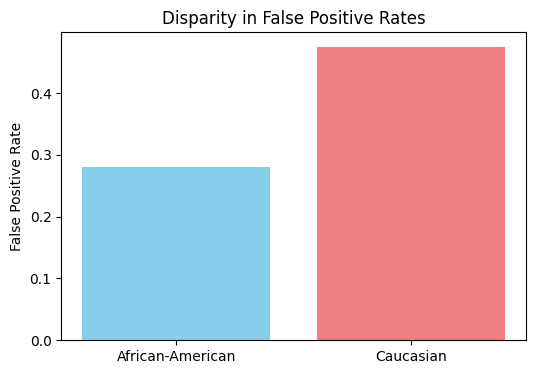

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

# Unprivileged group (African-American)
df_unpriv = df_filtered[df_filtered['race'] == 'African-American']
dataset_unpriv = StandardDataset(
    df_unpriv,
    label_name='two_year_recid',
    favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[['Caucasian']],
    categorical_features=['sex', 'c_charge_degree', 'c_charge_desc']
)
dataset_classified_unpriv = dataset_unpriv.copy()
dataset_classified_unpriv.labels = (df_unpriv['decile_score'] > 4).astype(int).values.reshape(-1,1)
metric_unpriv = ClassificationMetric(dataset_unpriv, dataset_classified_unpriv)
fpr_unprivileged = metric_unpriv.false_positive_rate()

# Privileged group (Caucasian)
df_priv = df_filtered[df_filtered['race'] == 'Caucasian']
dataset_priv = StandardDataset(
    df_priv,
    label_name='two_year_recid',
    favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[['Caucasian']],
    categorical_features=['sex', 'c_charge_degree', 'c_charge_desc']
)
dataset_classified_priv = dataset_priv.copy()
dataset_classified_priv.labels = (df_priv['decile_score'] > 4).astype(int).values.reshape(-1,1)
metric_priv = ClassificationMetric(dataset_priv, dataset_classified_priv)
fpr_privileged = metric_priv.false_positive_rate()

print(f"False Positive Rate (African-American): {fpr_unprivileged}")
print(f"False Positive Rate (Caucasian): {fpr_privileged}")

# Create a bar chart
labels = ['African-American', 'Caucasian']
fpr_values = [fpr_unprivileged, fpr_privileged]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(labels, fpr_values, color=['skyblue', 'lightcoral'])

# Add labels and title
ax.set_ylabel('False Positive Rate')
ax.set_title('Disparity in False Positive Rates')

# Display the plot
plt.show()

False Negative Rate (African-American): 0.44854586129753915
False Negative Rate (Caucasian): 0.23450134770889489


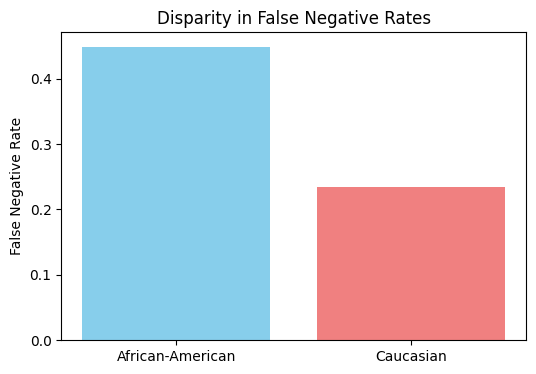

In [19]:
import matplotlib.pyplot as plt

# Calculate false negative rates
fnr_unprivileged = metric_unpriv.false_negative_rate()
fnr_privileged = metric_priv.false_negative_rate()

print(f"False Negative Rate (African-American): {fnr_unprivileged}")
print(f"False Negative Rate (Caucasian): {fnr_privileged}")

# Create a bar chart
labels = ['African-American', 'Caucasian']
fnr_values = [fnr_unprivileged, fnr_privileged]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(labels, fnr_values, color=['skyblue', 'lightcoral'])

# Add labels and title
ax.set_ylabel('False Negative Rate')
ax.set_title('Disparity in False Negative Rates')

# Display the plot
plt.show()

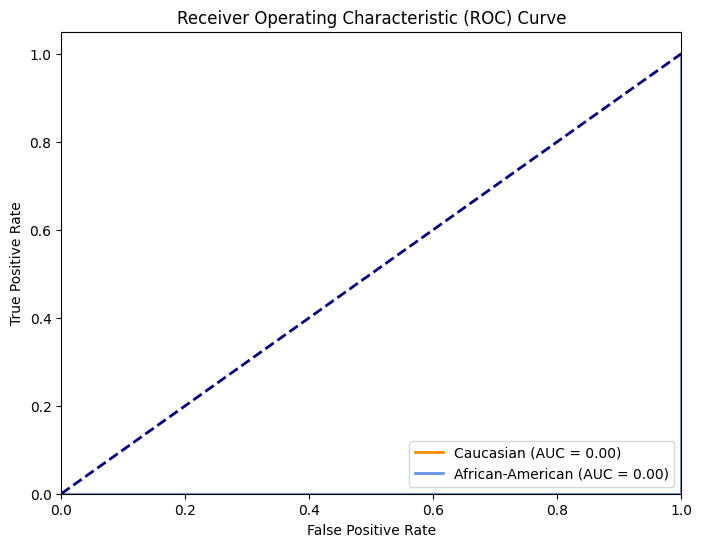

In [20]:
from sklearn.metrics import roc_curve, auc

# Get the scores and labels for each group
y_true_priv = dataset_priv.labels.ravel()
y_pred_priv = dataset_classified_priv.scores.ravel()

y_true_unpriv = dataset_unpriv.labels.ravel()
y_pred_unpriv = dataset_classified_unpriv.scores.ravel()

# Compute ROC curve and ROC area for each group
fpr_priv, tpr_priv, _ = roc_curve(y_true_priv, y_pred_priv)
roc_auc_priv = auc(fpr_priv, tpr_priv)

fpr_unpriv, tpr_unpriv, _ = roc_curve(y_true_unpriv, y_pred_unpriv)
roc_auc_unpriv = auc(fpr_unpriv, tpr_unpriv)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_priv, tpr_priv, color='darkorange', lw=2, label=f'Caucasian (AUC = {roc_auc_priv:.2f})')
plt.plot(fpr_unpriv, tpr_unpriv, color='cornflowerblue', lw=2, label=f'African-American (AUC = {roc_auc_unpriv:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Summary:

### Data Analysis Key Findings

* The COMPAS dataset was successfully loaded from a CSV file hosted online after an attempt to load from a local, empty SQLite database failed.
* The data was filtered to include only African-American and Caucasian individuals, focusing the analysis on these two racial groups.
* The data was successfully formatted into an `aif360.datasets.StandardDataset` object, defining 'race' as the protected attribute (Caucasian as privileged) and 'two\_year\_recid' as the target variable (0 as favorable).
* The Disparate Impact metric was calculated as 1.0, which typically indicates no disparate impact, but this metric only considers the ratio of favorable outcomes.
* The Equal Opportunity Difference and Average Absolute Odds Difference were both 0.0, suggesting similar true positive rates and overall accuracy across groups.
* The Theil Index, measuring inequality in outcome distribution, was calculated as approximately 0.058, indicating some level of inequality in how risk scores are distributed.
* A significant disparity was found in False Positive Rates: approximately 0.28 for African-Americans and approximately 0.47 for Caucasians. This means Caucasian individuals who did not recidivate were more likely to be incorrectly predicted as high-risk compared to African-Americans.
* A bar chart visualization clearly illustrates the higher False Positive Rate for the Caucasian group.

### Insights or Next Steps

* While some fairness metrics suggest equity (Disparate Impact, Equal Opportunity Difference, Average Absolute Odds Difference), the significant disparity in False Positive Rates indicates that the *types* of errors made by the COMPAS tool differ between racial groups, with Caucasians more likely to be falsely labeled high-risk.
* Future steps should focus on applying post-processing bias mitigation techniques designed to equalize false positive and false negative rates, such as Equalized Odds Postprocessing, and conducting further investigation into the model's features and their potential influence on this specific type of error disparity.